In [153]:
import pandas as pd
import geopandas as gpd
import libpysal
import numpy as np
import matplotlib.pyplot as plt
import esda
from sklearn.decomposition import PCA

In [150]:
london = gpd.read_file('source/London_Borough_Excluding_MHW.shp')
london_eu = pd.read_csv('source/london_eu.csv')
london_data = pd.merge(london,london_eu, on='NAME', how='inner')
london_data.rename(columns={'Column1':'ID'}, inplace=True)
london_data['Pct_Rejected'] = london_data['Pct_Rejected'].astype('float64')
london_data['TOTAL_POP'] = london_data['TOTAL_POP'].astype('float64')
london_data['Electorate'] = london_data['Electorate'].astype('float64')
london_data['Votes_Cast'] = london_data['Votes_Cast'].astype('float64')
london_data['Remain'] = london_data['Remain'].astype('float64')
london_data['Leave'] = london_data['Leave'].astype('float64')
london_data['Rejected_Ballots'] = london_data['Rejected_Ballots'].astype('float64')

In [149]:
london_data.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,ID,TOTAL_POP,Electorate,Votes_Cast,Remain,Leave,Rejected_Ballots,Pct_Remain,Pct_Leave,Pct_Rejected,Assembly
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",31,173525.0,108838,85330,52533,32737,60,61.61,38.39,7.0,Con
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",18,379031.0,245349,171289,92913,78221,155,54.29,45.71,9.0,Con
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",16,324857.0,231473,182570,92398,90034,138,50.65,49.35,8.0,Con
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",28,268770.0,165050,115208,58755,56321,132,51.06,48.94,11.0,Lab
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",19,343059.0,212991,149268,90024,59017,227,60.40,39.60,15.0,Lab


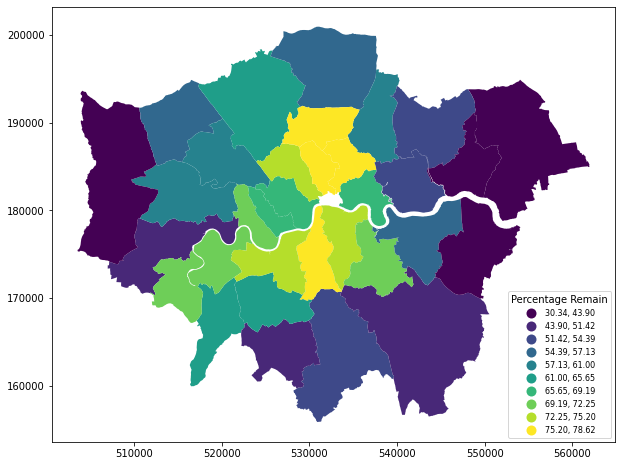

In [33]:
ax = london_data.plot(column='Pct_Remain', cmap='viridis', figsize=(12, 8), scheme='quantiles', k=10, legend=True, 
                      legend_kwds={'loc': 'lower right', 'title': 'Percentage Remain', 'fontsize': 8})

In [142]:
london_data["NEIGHBORS"] = None  

for index, borough in london_data.iterrows():   
    neighbors = london_data[~london_data.geometry.disjoint(borough.geometry)].ID.tolist()
    neighbors = [id for id in neighbors if borough.ID != id]
    london_data.at[index, "NEIGHBORS"] = ' '.join(map(str, neighbors))

london_data[['ID','NEIGHBORS']].head()

,ID,NEIGHBORS
0,31,7 5 2 10
1,18,16 32 7 2
2,16,18 32 6 1 21 14
3,28,19 27 5 23
4,19,28 27 25 15 23


In [73]:
boroughs = london_data.ID.astype('str').tolist()
n_list = list(zip(london_data.ID.astype('str').tolist(), [x.split() for x in london_data.NEIGHBORS]))

In [74]:
neighbors = {}

for t in n_list:
    k = t[0]
    values = t[1]
    neighbors[k]={}
    for v in values:
        neighbors[k][v]=1

In [78]:
weights = libpysal.weights.weights.W(neighbors, id_order=london_data.ID.astype('str').tolist())
weights.n

32

In [117]:
def local_getisord(feature, w=weights, perm=99):
    y = np.array(feature)
    g = esda.getisord.G_Local(y, weights, star=True, permutations=perm)
    score = g.z_sim
    
    return score

In [98]:
remain = london_data[['ID','Pct_Remain']].copy()
remain.index = remain.ID
remain.drop('ID', axis=1, inplace=True)
remain.head()

,Pct_Remain
ID,
31,61.61
18,54.29
16,50.65
28,51.06
19,60.40


In [134]:
remain = remain.apply(local_getisord)

c:\Python310\lib\site-packages\esda\getisord.py:596: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


In [119]:
remain.rename(columns={'Pct_Remain':'G_Local_Remain'}, inplace=True)
london_data = pd.merge(london_data,remain, on='ID', how='inner')

Text(0.5, 1.0, 'Local Getis-Ord G* Remain')

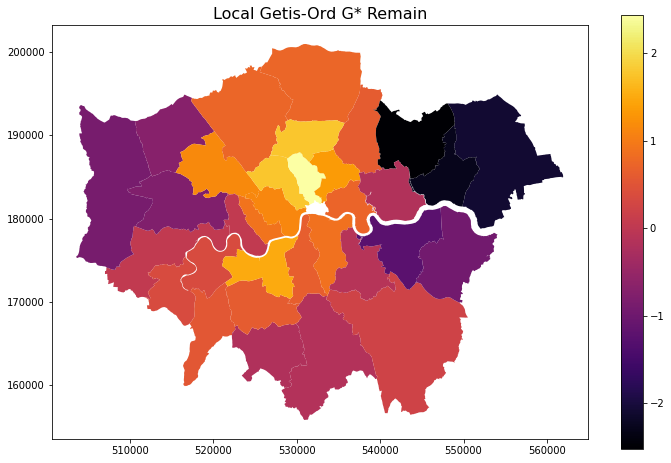

In [129]:
ax = london_data.plot(column='G_Local_Remain', cmap='inferno', figsize=(12, 8), legend=True)
ax.set_title('Local Getis-Ord G* Remain', fontsize=16)

The z-score is statistically significant when outside of [-1.645, 1.645], as such the three lowest and three highest scoring boroughs are significantly clustered with respectively low and high values.

In [124]:
leave = london_data[['ID','Pct_Leave']].copy()
leave.index = leave.ID
leave.drop('ID', axis=1, inplace=True)
leave.head()

,Pct_Leave
ID,
31,38.39
18,45.71
16,49.35
28,48.94
19,39.60


In [125]:
leave = leave.apply(local_getisord)

c:\Python310\lib\site-packages\esda\getisord.py:596: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


In [126]:
leave.rename(columns={'Pct_Leave':'G_Local_Leave'}, inplace=True)
london_data = pd.merge(london_data,leave, on='ID', how='inner')

Text(0.5, 1.0, 'Local Getis-Ord G* Leave')

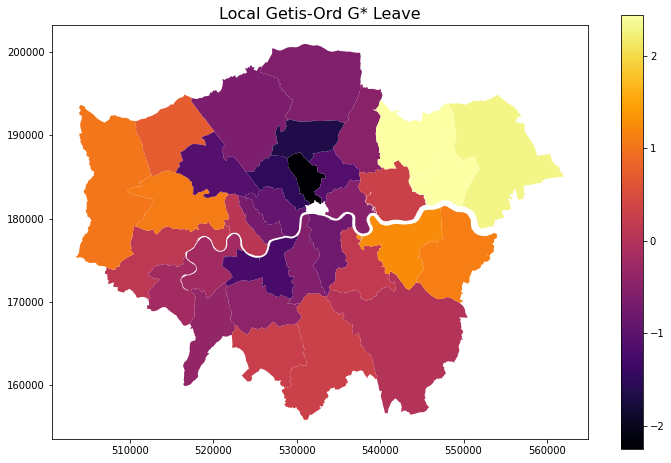

In [130]:
ax = london_data.plot(column='G_Local_Leave', cmap='inferno', figsize=(12, 8), legend=True)
ax.set_title('Local Getis-Ord G* Leave', fontsize=16)

In [143]:
rejected = london_data[['ID','Pct_Rejected']].copy()
rejected.index = rejected.ID
rejected.drop('ID', axis=1, inplace=True)
rejected.head()

,Pct_Rejected
ID,
31,7.0
18,9.0
16,8.0
28,11.0
19,15.0


In [144]:
rejected = rejected.apply(local_getisord)

c:\Python310\lib\site-packages\esda\getisord.py:596: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


In [145]:
rejected.rename(columns={'Pct_Rejected':'G_Local_Rejected'}, inplace=True)
london_data = pd.merge(london_data,rejected, on='ID', how='inner')

Text(0.5, 1.0, 'Local Getis-Ord G* Rejected')

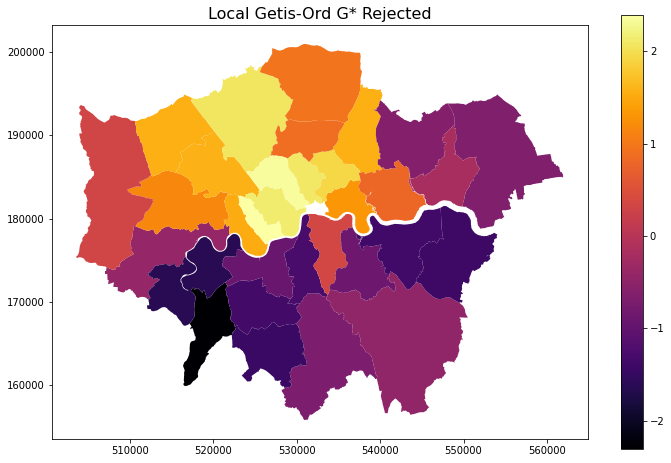

In [146]:
ax = london_data.plot(column='G_Local_Rejected', cmap='inferno', figsize=(12, 8), legend=True)
ax.set_title('Local Getis-Ord G* Rejected', fontsize=16)

In [151]:
full_data = london_data[['HECTARES','NONLD_AREA','ID','TOTAL_POP','Electorate','Votes_Cast','Remain','Leave','Rejected_Ballots','Pct_Remain','Pct_Leave','Pct_Rejected']].copy()
full_data.index = full_data.ID
full_data.drop('ID', axis=1, inplace=True)
full_data.head()

,HECTARES,NONLD_AREA,TOTAL_POP,Electorate,Votes_Cast,Remain,Leave,Rejected_Ballots,Pct_Remain,Pct_Leave,Pct_Rejected
ID,,,,,,,,,,,
31,3726.117,0.000,173525.0,108838.0,85330.0,52533.0,32737.0,60.0,61.61,38.39,7.0
18,8649.441,0.000,379031.0,245349.0,171289.0,92913.0,78221.0,155.0,54.29,45.71,9.0
16,15013.487,0.000,324857.0,231473.0,182570.0,92398.0,90034.0,138.0,50.65,49.35,8.0
28,5658.541,60.755,268770.0,165050.0,115208.0,58755.0,56321.0,132.0,51.06,48.94,11.0
19,5554.428,0.000,343059.0,212991.0,149268.0,90024.0,59017.0,227.0,60.40,39.60,15.0


In [152]:
full_data = full_data.apply(local_getisord)

c:\Python310\lib\site-packages\esda\getisord.py:596: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(
c:\Python310\lib\site-packages\esda\getisord.py:596: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(
c:\Python310\lib\site-packages\esda\getisord

In [154]:
pca = PCA(n_components=3)

In [155]:
principalComponents = pca.fit_transform(full_data)

In [159]:
pca_data = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2', 'pc3'])
pca_data['ID'] = full_data.index

In [160]:
pca_data.head()

,pc1,pc2,pc3,ID
0,0.023992,2.091825,3.610171,31
1,1.738515,-0.465503,0.675917,18
2,3.025307,-2.484185,0.306246,16
3,0.371012,1.025192,0.503648,28
4,-0.055353,1.142130,-1.972892,19


In [162]:
feature_names = pd.DataFrame(pca.components_, columns=full_data.columns, index = ['pc1','pc2', 'pc3']).transpose()
feature_names

,pc1,pc2,pc3
HECTARES,0.354238,-0.082356,-0.085872
NONLD_AREA,0.241123,0.172771,-0.054370
TOTAL_POP,0.131376,-0.321250,-0.276815
Electorate,0.321049,-0.355552,-0.053245
Votes_Cast,0.391517,-0.380957,0.108718
Remain,0.081328,-0.458342,0.297856
Leave,0.413437,0.013142,-0.196894
Rejected_Ballots,-0.128648,-0.350311,-0.467064
Pct_Remain,-0.324585,-0.337564,0.308229
Pct_Leave,0.298002,0.328301,-0.294698
